In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import pendulum

# Goal of the project
The goal of this project is to learn a policy for an inverted pendulum model to make it do a swing-up motion. Beyond the task of inverting a pendulum, the goal is to also gain an understanding on how value iteration and Q-learning work, their limitations and advantages.

To make the problem interesting, the inverted pendulum has a limit on the maximum torque it can apply, therefore it is necessary for the pendulum to do a few "back and forth" motions to be able to reach the inverted position ($\theta=\pi$) from the standing still non-inverted position ($\theta=0$). 

<img src='./pendulum.png' width="120">

In the following, we will write $x = \begin{pmatrix} \theta \\ \dot{\theta} \end{pmatrix}$ as the vector of states of the system. We will also work with time-discretized dynamics, and refer to $x_n$ as the state at time $t = n \Delta t$ (assuming discretization time $\Delta t$)

We want to minimize the following discounted cost function
$$\sum_{i=0}^{\infty} \alpha^i g(x_i, u_i)$$ where 
$$g(x_i, u_i) = (\theta-\pi)^2 + 0.01 \cdot \dot{\theta}_i^2 + 0.0001 \cdot u_i^2 \qquad \textrm{and} \qquad\alpha=0.99$$
This cost mostly penalizes deviations from the inverted position but also encourages small velocities and control.

## Part 1 - Value iteration with a model
In the first part, we will implement the value iteration algorithm, which requires us to have a model of the robot dynamics, i.e. we need to be able to know the next state $x_{n+1}$ given $(x_n, u_n)$. To that end, we are given a robot (defined in the package ```pendulum.py```) with a function ```next_state(x,u)``` that returns $x_{n+1}$ given $(x_n, u_n)$.

In [3]:
# we can create a robot
robot = pendulum.Pendulum()

# assume we set theta and dtheta = 0 and u = -5, we can get the next state using
x = np.array([0,0])
u = -5
x_next = robot.next_state(x, u)
print(x_next)

[ 6.26078821 -0.49412629]


We also need to discretize the state space, we discretize $\theta \in [0, 2\pi]$ in 50 states and $\dot{\theta} \in [-6, 6]$ is 50 states. For example:

In [4]:
# we don't want 2pi to be in the set because it's the same as 0
discretized_theta = np.linspace(0, 2*np.pi, 50, endpoint=False)

discretized_thetadot = np.linspace(-6, 6, 50)

# now given an arbitrary continuous state theta
theta_arbitrary = 0.23471

# we can find the index of the closest element in the set of discretized states
index_in_discretized_theta = np.argmin(np.abs(discretized_theta - theta_arbitrary))

# and find the closed discretized state
closest_state = discretized_theta[index_in_discretized_theta]
print(f'the discretized theta closest to {theta_arbitrary} is {closest_state} with index {index_in_discretized_theta}')

the discretized theta closest to 0.23471 is 0.25132741228718347 with index 2


1. Write a function that implements the value iteration algorithm ```value_iteration(robot)``` that takes as an input the robot model (to use ```robot.next_state```) and returns two 50x50 arrays, one for the value function and one for the optimal policy.

2. Compute the optimal value function and policy when $u$ has three possible value $\{-5, 0, 5\}$ (plot these functions as 2D images - cf. below). How many iterations of the value iteration algorithm are necessary to converge?(assume convergence when no value changes more than $10^{-2}$ after an iteration and initialize the first guess for the value function to 0). Using the simulate / animate functions (cf. below) how many back and forth of the pendulum are necessary to go from $x = [0,0]$ to the fully inverted position?

3. Answer the same questions when $u \in \{-3, 0 ,3\}$

4. Answer the same questions when $u \in \{-5, 0 ,5\}$ and we use a "sparse" cost function, i.e. a cost function where every state apart from the states close to being inverted have the same cost $g(x,u) = \left\{ \begin{array}{l} 0 \quad \textrm{if } |\theta - \pi| < 0.2 \\ 1 \quad \textrm{otherwise} \end{array} \right.$

5. What are the advantages and disadvantages of using the value iteration algorithm? Could we use the same algorithm for a more complicated robot? Why?

## 1.1 implement the value iteration algorithm

In [5]:
# question 1
nq=50
nv=50
nu = 3
v_max = 6
u_max=5
# create lookup tables for discretized states
u_table = np.linspace(-u_max, u_max, nu)
q_table = np.linspace(0., 2*np.pi, nq, endpoint=False)
v_table = np.linspace(-v_max, v_max, nv)

num_states = nq * nv

In [6]:
def get_index(x):
    ind_q = np.argmin((x[0]-q_table)**2)
    ind_v = np.argmin((x[1]-v_table)**2)
    return ind_q + ind_v*nq

def get_states(index):
    iv,ix = np.divmod(index, nq)
    return np.array([q_table[ix], v_table[iv]])  

next_state_index = np.empty([num_states, nu], dtype=np.int32)
for i in range(num_states):
    for k in range(nu):
        x_next = robot.next_state(get_states(i),u_table[k])
        next_state_index[i,k] = get_index(x_next)

In [7]:
def cost(x,u):
    """
    a cost function for the inverted pendulum
    """
    return (x[0]-np.pi)**2 + 0.01*x[1]**2 + 0.0001*u**2

In [8]:
class ValueIteration:
    """
    This class is used to implement value iteration and store the state of the value function and policy
    as we iterate
    """
    def __init__(self, model,num_states, cost, discount_factor=0.99):
        """
        receives as input a pendulum and cost function and potentially a discount factor
        """
        
        # value function stored as a 1D array (indexed as we indexed states in pendulum)
        self.num_states=num_states
        self.value_function = np.zeros([self.num_states])
        # we also store the policy similarly
        self.policy = np.zeros([self.num_states])
        # references to the pendulum and cost function
        self.model = model
        self.cost = cost
        
        #discount factor for cost
        self.gamma = discount_factor
                
    def iterate(self,num_states,nu,u_table, num_iter=1):
        """
        the main iteration of value iteration
        num_iter: maximum number of iterations to be performed. 
        
        If after an iteration the value function does not change (e.g. less thant 10e-5)
        the function returns and print success
        """
        for i in range(num_iter):
            J_new = self.value_function.copy()
            for j in range(num_states):
                #for each possible control input we compute the cost
                r = np.zeros([nu])
                for l in range(nu):
                    # the current states and control
                    x = get_states(j)
                    u = u_table[l]
                    # the index for the next state
                    next_index = next_state_index[j,l]
                    #compute the cost
                    r[l] = self.cost(x, u) + self.gamma*self.value_function[next_index]
                    
                # we take the smallest cost value to update the value function
                J_new[j] = np.min(r)
                #here we also store the policy (so we have it for later)
                self.policy[j] = u_table[np.argmin(r)]
                
            #we update the current value function if there is any change otherwise we are done
            if ((self.value_function-J_new)**2 < 10e-2).all():
                print("CONVERGED after iteration " + str(i))
                break
            else:
                self.value_function = J_new.copy()
        
        
    

In [9]:
print(u_table)

[-5.  0.  5.]


## 1.2 iterations for converage

In [10]:
# we instanciate a value iteration object for a pendulum model and a cost function
value_iteration = ValueIteration(robot,num_states, cost)

# we run the iterations (with maximum number 2000).
value_iteration.iterate(num_states,nu,u_table,2000)

CONVERGED after iteration 28


about 28 iterations 

In [11]:
print(value_iteration.policy[0])

0.0


In [12]:
# policy=value_iteration.policy
# print(policy)

In [13]:
my_policy=value_iteration.policy

def policy(x):
#     print(x)
    index=get_index(x)
    return my_policy[index]

In [14]:
x0 = np.array([0.,0.])
x, u = robot.simulate(x0, policy, 20)

In [15]:
def plot_results(robot, value_function, policy,my_policy, animate=True):
    """
    This function plots the results. It displays the value function, the policy for all states.
    Then it integrates the pendulum from state [0,0] and displays the states and control as a function of time
    Finally it shows an animation of the result
    """
    x0 = np.array([0.,0.])

    x, u = robot.simulate(x0, policy, 20)

#     plt.figure(figsize=[6,6])
#     plt.imshow(value_function.reshape((nq, nv)), extent=[0., 2*np.pi, -v_max,v_max], aspect='auto')
#     plt.xlabel('Pendulum Angle')
#     plt.ylabel('Velocity')
#     plt.title('Value Function')

#     plt.figure(figsize=[6,6])
#     plt.imshow(my_policy.reshape((nq, nv)), extent=[0., 2*np.pi, -v_max, v_max], aspect='auto')
#     plt.xlabel('Pendulum Angle')
#     plt.ylabel('Velocity')
#     plt.title('Policy')

#     time = np.linspace(0.,20., len(x[0,:]))
#     plt.figure()
#     plt.subplot(3,1,1)
#     plt.plot(time,x[0,:])
#     plt.ylabel('angle')
#     plt.subplot(3,1,2)
#     plt.plot(time,x[1,:])
#     plt.ylabel('velocity')
#     plt.subplot(3,1,3)
#     plt.plot(time[:-1],u)
#     plt.ylabel('control')
    if animate:
        robot.animate_robot(x, robot.delta_t)

In [16]:

def plot_value_function(value_function,nq,nv,v_max):
    plt.figure(figsize=[6,6])
    plt.imshow(value_function.reshape((nq, nv)), extent=[0., 2*np.pi, -v_max,v_max], aspect='auto')
    plt.xlabel('Pendulum Angle')
    plt.ylabel('Velocity')
    plt.title('Value Function')


In [17]:
def plot_policy(nq,nv,v_max,my_policy):
    plt.figure(figsize=[6,6])
    plt.imshow(my_policy.reshape((nq, nv)), extent=[0., 2*np.pi, -v_max, v_max], aspect='auto')
    plt.xlabel('Pendulum Angle')
    plt.ylabel('Velocity')
    plt.title('Policy')


In [18]:
def plot_control_velocity_angle(x,u):
    time = np.linspace(0.,20., len(x[0,:]))
    plt.figure()
    plt.subplot(3,1,1)
    plt.plot(time,x[0,:])
    plt.ylabel('angle')
    plt.subplot(3,1,2)
    plt.plot(time,x[1,:])
    plt.ylabel('velocity')
    plt.subplot(3,1,3)
    plt.plot(time[:-1],u)
    plt.ylabel('control')

<IPython.core.display.Javascript object>


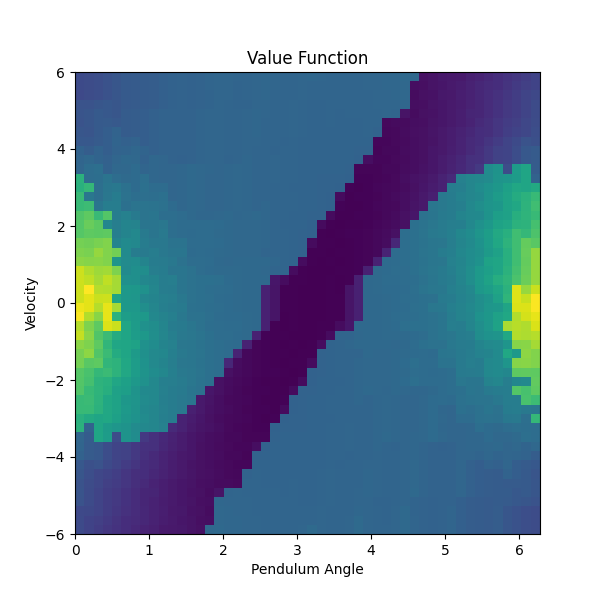

In [19]:
value_function=value_iteration.value_function

x0 = np.array([0.,0.])

x, u = robot.simulate(x0, policy, 20)
plot_value_function(value_function,nq,nv,v_max)


<IPython.core.display.Javascript object>


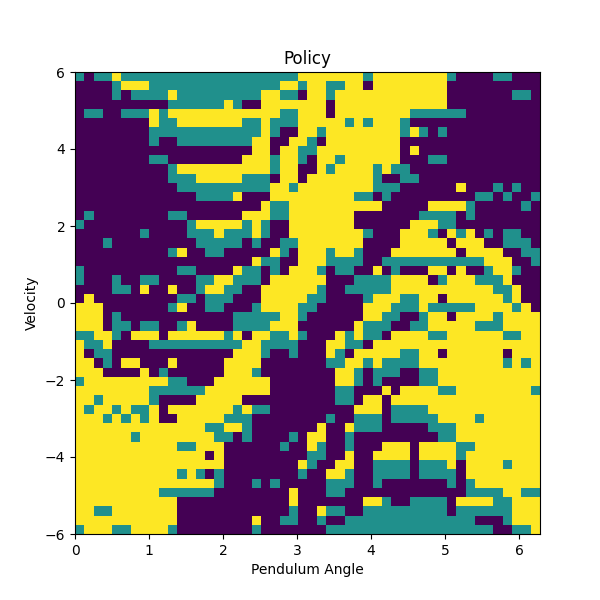

In [20]:
plot_policy(nq,nv,v_max,my_policy)

<IPython.core.display.Javascript object>


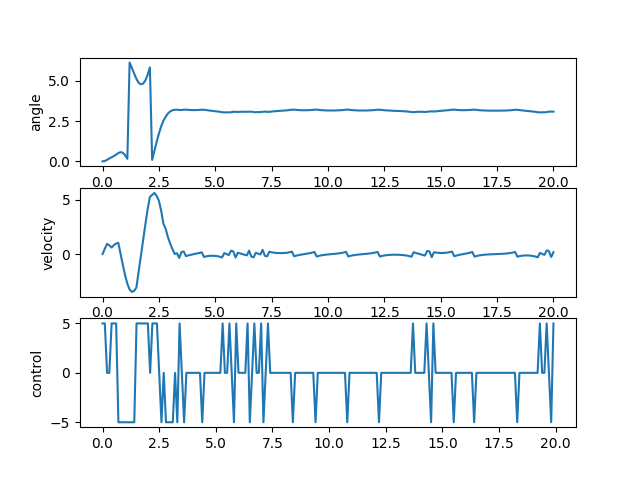

In [21]:
plot_control_velocity_angle(x,u)

In [22]:
# we plot the results
plot_results(robot, value_iteration.value_function, policy,my_policy, animate=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAun5tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzA0OCBiODZhZTNjIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DSdliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOOM8Ue0I9hJLKvPs/l
qmb6oagJo7SFBr1OBuUCQQFG2xsmgmMN/KGNBIqjFM17HZsrECpFM2gzb3sRbGaX3YXhKCoBr2Vv
Btnz7czyXRN90c1rKBwG6h7+y1G9RctmKdYkNfZ9PIcL6+yDtJIOH1UIAuj9/wue2ZtEw6TSqBcK
L8eOssBoMcX7PXzJUsrbPviIbDjdWE10mfuw6TofcTbVsC7GFr0ZwVPYH+AOycAUFjmAGJk95XFX
RxCqPJz61rNvSkCKxJc2DnDq23y1nGBZ0W7xxqpU/igREKd8+qFqImDJ6q/ECIqJRDeL1+W9gvs0
B80Nn771qo1L6r8JJWhIyfsnvASOIfl+rVzNt0o2qwOxtlViXrpFGFdX+hJ/+A42nrNzSIvQobCb
1WYV+0aZtiJfPn6w1PvG4sdtX+BT8hpKEx+lGo4fw7gE1OQzWCRSf/UNjadsZRLvGuvYUKCdwTEk
WfopPqa1ddCsc1nlIPX5fys0H90Iqbz/qYO8ABZaIWjQvl/bvZyxMzeSWpapBIGfgt9jxS/GqcPn
5qzL5Crt5M3tXI70PXm9Vla/HVaCxgPICI90bCsIyVc4u3PdLfonjvTAsNJVxmETQokGg2YmVSOf
r9cf7n4gzRN5w/yGp0C8urfaPNw7GLtuDKgU7CvsIolbNMN0bp4uNQArcYt3tWUUqb0q6OjBYObX
juYjxUGZABKLLHFN/6veiTXwCvzZQezV/g5HRLV1YnFqdeWGDbkCWfZmb1bEe4o0ZC8xjpEr120J
my/+CpVN/LCBb43mUw7YT7/K5nbUFjE2fWbHzRkNPuFoiIUAihHtmqc5GMh8KZmydt11qyMhkGLn
FFXrtho2ClWJWeetPg1hhapwI4HkY4/lqd7PdT98WYnH/7fy4MVhY8XXUGTwUhNXsk8tjiPqeltX
ADyJRFFavntZkvu+zaX28uMbT6WM/MgzebP/5IgawXlFJWPgLbOX+bgXnmLrhUWxSjN3LOg4AVp4
GpLl2iUNdOEv24+I0WdswW69aIpab8sMQYo9BbKBotiaDRx+0fC427CuVpPCqyTnUBKn+gAX/8xj
yDIXb44+UHklBUWL3yDAQcoTDpE3sefTRQ4U9sUJGj2kFGltXifbADJsIu7CSHyhtgvd+57WFbDZ
rGkINclUJgrid2M2br78Wa6I16nezLC5Y4+Mg5XplCcOVZNENDUSvU5Fjc2umXdketI4v3JtltNI
lMLf8ZvD2Ct4L4VkDbV8ldY3b2loU5XObNAR21z6j6aCsOaps3mK/4YgXoG2DMw3uyw6wHLHrn2P
sg/8lT2Y98QB3tktKDfI2N9VydPYu5EcURN/pIHIPiyUrknf0Ptng9bnP4bPekLrAfdxelssXXf3
sp9XLaQEqF2qFutiDrCmCwwJqXT6jt7Oo/muRsyRhSfyRsh7UpZCEZwoJQAxYKbcZcHoLktxVXZy
J4ejWW/M7qlkyY5XvP6uJYEZbRPbFZS9MCg6Oni3/wK2TDiXzwC40WumY64v8gxQqJcJgsGgDxgn
N+Zhq7LFPy7foC2P3W98XwoaKBAlF8YQBbKks9MxT9NZa4jSmi/kBNxVaQ9nni3xvHlfg9BNP0Pq
i57axPTmOMTD6dKrtiP/TLDmAdk9rh8aWsyiHInhOFr7LVMszy7gG+WIWBGRHhLRqmAvxUSKlefi
FK0tNHVtAZkjYxRJRn6AlD/2RvshFfVOQmuqxkzzPMjjpcYEeveyB4jHtVnxlLv/ao3FPvv0k1AK
mN+Ytl6UdogByqwWLE0vr9yfMjko3Za4PXtR7mlIFHtDWN7ofEKV2LCgDQjkTNVI28K/nGQ14+jJ
ZVs9EnW63FPEp2wyseafy+uVaEkc+T0bnatI1+YsUXKe3CJRAN+F8nDZ98UGnNp2Vgag4kOpcimq
40fRjFjl2Fek9sN70gzwgT58wwfJa6iyH1XvF6qJ063Qmg3O1OL2STtvdFBXHYlRdeTYhdrRj1iA
Ntpz/3aWMmXOT9l2VdjHsqna9ITCAXNaBtUVF4X/cb7DVIa8lUnkGyY9DGqO4lr3aXJ9ECMWjHsA
mNQhhsYgqcFvfdx5vKdkKj4Ax0XYsufnq0HMdMFZZU6f9xBj9Gzoga5eCuA1tXWxebMyuNh+fh20
mdeGj1HCEAus/EpPypuJVRV9S+UjzSiXUnYi7sMvERtA5NZlLGHHXbNO6j6WrgrAdhJRTV08f1MB
ebrQLRpFOp4BUjbb4MfloHAO7bDkImgSsHheYbSAD4FmJPOGU5FfNUepzyfuKAckDt1ERQADmt0I
MdY1jGkMTbG0C3ycAAADAABUgCOjpBnneEKkf//pV8EHcI45CerIx1PCvdnC0Z4L6VKHkawb9A8R
p3IQ6AWtbVQuG6s+KnkGbXox5ApId1B3NEC432mrpV/xv1dHWfrFA+LL/q5iwXcfYleOTooPQk40
6aw9pWZ4AQcyyUD15znrY+wBo53qzl1Xy6byTY2LIHLYHdQwooPem2HURMaQWu5y7eBOB/lOgE/U
XtfqjVbHy2yVn5W8raCmK0A9uwE8TvVdA18lO7TzQau6yGCZzpZdab2dJxbAfHHVAfy3qih36h/G
I3WoozPCOOD1RwhTETSN7818xX0CXE91U6I5/1TtHih2Y8OgqmS+nbHjcBQOAf9gIm3amaWq7/Ar
+FaIw5dlawKT8ueIkD8QKCYdn5FMNV0HFQPWZP2a7Uv/xUkszGbQhZRfSrfs2K+WOjCzh8CYZMr9
wo/twBvAHAYt8YEI30JZ6

In [23]:
nq=50
nv=50
nu = 3
v_max = 6
u_max=3
# create lookup tables for discretized states
u_table = np.linspace(-u_max, u_max, nu)
q_table = np.linspace(0., 2*np.pi, nq, endpoint=False)
v_table = np.linspace(-v_max, v_max, nv)

num_states = nq * nv

In [24]:
def get_index(x):
    ind_q = np.argmin((x[0]-q_table)**2)
    ind_v = np.argmin((x[1]-v_table)**2)
    return ind_q + ind_v*nq

def get_states(index):
    iv,ix = np.divmod(index, nq)
    return np.array([q_table[ix], v_table[iv]])  

next_state_index = np.empty([num_states, nu], dtype=np.int32)
for i in range(num_states):
    for k in range(nu):
        x_next = robot.next_state(get_states(i),u_table[k])
        next_state_index[i,k] = get_index(x_next)

In [25]:
print(u_table)

[-3.  0.  3.]


In [26]:
# we instanciate a value iteration object for a pendulum model and a cost function
value_iteration = ValueIteration(robot,num_states, cost)

# we run the iterations (with maximum number 2000).
value_iteration.iterate(num_states,nu,u_table,2000)

CONVERGED after iteration 42


<IPython.core.display.Javascript object>


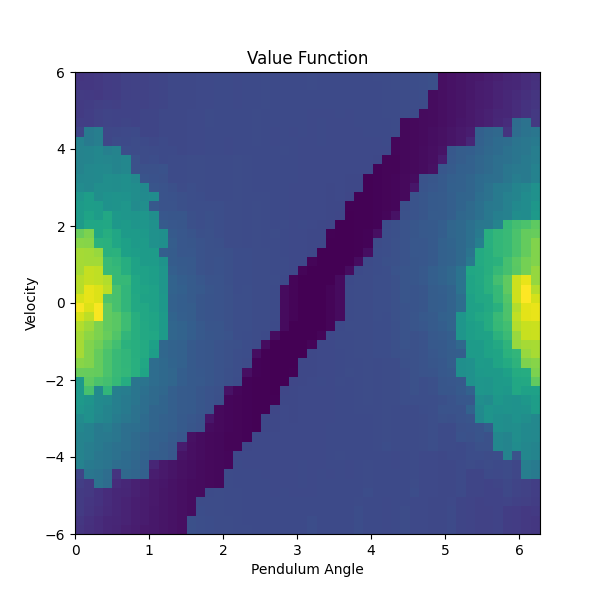

In [27]:
value_function=value_iteration.value_function

x0 = np.array([0.,0.])

x, u = robot.simulate(x0, policy, 20)
plot_value_function(value_function,nq,nv,v_max)

<IPython.core.display.Javascript object>


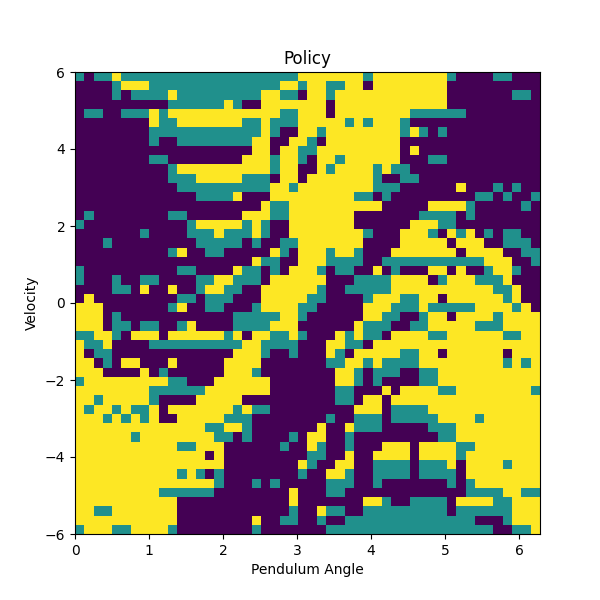

In [28]:
plot_policy(nq,nv,v_max,my_policy)

<IPython.core.display.Javascript object>


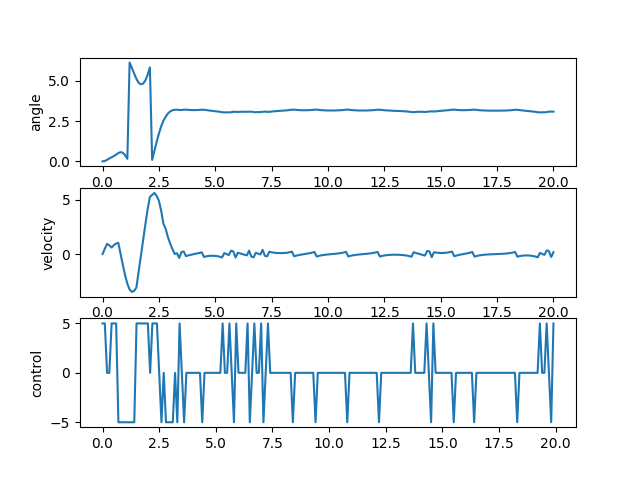

In [29]:
plot_control_velocity_angle(x,u)

In [30]:
# we plot the results
plot_results(robot, value_iteration.value_function, policy,my_policy, animate=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAun5tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzA0OCBiODZhZTNjIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DSdliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOOM8Ue0I9hJLKvPs/l
qmb6oagJo7SFBr1OBuUCQQFG2xsmgmMN/KGNBIqjFM17HZsrECpFM2gzb3sRbGaX3YXhKCoBr2Vv
Btnz7czyXRN90c1rKBwG6h7+y1G9RctmKdYkNfZ9PIcL6+yDtJIOH1UIAuj9/wue2ZtEw6TSqBcK
L8eOssBoMcX7PXzJUsrbPviIbDjdWE10mfuw6TofcTbVsC7GFr0ZwVPYH+AOycAUFjmAGJk95XFX
RxCqPJz61rNvSkCKxJc2DnDq23y1nGBZ0W7xxqpU/igREKd8+qFqImDJ6q/ECIqJRDeL1+W9gvs0
B80Nn771qo1L6r8JJWhIyfsnvASOIfl+rVzNt0o2qwOxtlViXrpFGFdX+hJ/+A42nrNzSIvQobCb
1WYV+0aZtiJfPn6w1PvG4sdtX+BT8hpKEx+lGo4fw7gE1OQzWCRSf/UNjadsZRLvGuvYUKCdwTEk
WfopPqa1ddCsc1nlIPX5fys0H90Iqbz/qYO8ABZaIWjQvl/bvZyxMzeSWpapBIGfgt9jxS/GqcPn
5qzL5Crt5M3tXI70PXm9Vla/HVaCxgPICI90bCsIyVc4u3PdLfonjvTAsNJVxmETQokGg2YmVSOf
r9cf7n4gzRN5w/yGp0C8urfaPNw7GLtuDKgU7CvsIolbNMN0bp4uNQArcYt3tWUUqb0q6OjBYObX
juYjxUGZABKLLHFN/6veiTXwCvzZQezV/g5HRLV1YnFqdeWGDbkCWfZmb1bEe4o0ZC8xjpEr120J
my/+CpVN/LCBb43mUw7YT7/K5nbUFjE2fWbHzRkNPuFoiIUAihHtmqc5GMh8KZmydt11qyMhkGLn
FFXrtho2ClWJWeetPg1hhapwI4HkY4/lqd7PdT98WYnH/7fy4MVhY8XXUGTwUhNXsk8tjiPqeltX
ADyJRFFavntZkvu+zaX28uMbT6WM/MgzebP/5IgawXlFJWPgLbOX+bgXnmLrhUWxSjN3LOg4AVp4
GpLl2iUNdOEv24+I0WdswW69aIpab8sMQYo9BbKBotiaDRx+0fC427CuVpPCqyTnUBKn+gAX/8xj
yDIXb44+UHklBUWL3yDAQcoTDpE3sefTRQ4U9sUJGj2kFGltXifbADJsIu7CSHyhtgvd+57WFbDZ
rGkINclUJgrid2M2br78Wa6I16nezLC5Y4+Mg5XplCcOVZNENDUSvU5Fjc2umXdketI4v3JtltNI
lMLf8ZvD2Ct4L4VkDbV8ldY3b2loU5XObNAR21z6j6aCsOaps3mK/4YgXoG2DMw3uyw6wHLHrn2P
sg/8lT2Y98QB3tktKDfI2N9VydPYu5EcURN/pIHIPiyUrknf0Ptng9bnP4bPekLrAfdxelssXXf3
sp9XLaQEqF2qFutiDrCmCwwJqXT6jt7Oo/muRsyRhSfyRsh7UpZCEZwoJQAxYKbcZcHoLktxVXZy
J4ejWW/M7qlkyY5XvP6uJYEZbRPbFZS9MCg6Oni3/wK2TDiXzwC40WumY64v8gxQqJcJgsGgDxgn
N+Zhq7LFPy7foC2P3W98XwoaKBAlF8YQBbKks9MxT9NZa4jSmi/kBNxVaQ9nni3xvHlfg9BNP0Pq
i57axPTmOMTD6dKrtiP/TLDmAdk9rh8aWsyiHInhOFr7LVMszy7gG+WIWBGRHhLRqmAvxUSKlefi
FK0tNHVtAZkjYxRJRn6AlD/2RvshFfVOQmuqxkzzPMjjpcYEeveyB4jHtVnxlLv/ao3FPvv0k1AK
mN+Ytl6UdogByqwWLE0vr9yfMjko3Za4PXtR7mlIFHtDWN7ofEKV2LCgDQjkTNVI28K/nGQ14+jJ
ZVs9EnW63FPEp2wyseafy+uVaEkc+T0bnatI1+YsUXKe3CJRAN+F8nDZ98UGnNp2Vgag4kOpcimq
40fRjFjl2Fek9sN70gzwgT58wwfJa6iyH1XvF6qJ063Qmg3O1OL2STtvdFBXHYlRdeTYhdrRj1iA
Ntpz/3aWMmXOT9l2VdjHsqna9ITCAXNaBtUVF4X/cb7DVIa8lUnkGyY9DGqO4lr3aXJ9ECMWjHsA
mNQhhsYgqcFvfdx5vKdkKj4Ax0XYsufnq0HMdMFZZU6f9xBj9Gzoga5eCuA1tXWxebMyuNh+fh20
mdeGj1HCEAus/EpPypuJVRV9S+UjzSiXUnYi7sMvERtA5NZlLGHHXbNO6j6WrgrAdhJRTV08f1MB
ebrQLRpFOp4BUjbb4MfloHAO7bDkImgSsHheYbSAD4FmJPOGU5FfNUepzyfuKAckDt1ERQADmt0I
MdY1jGkMTbG0C3ycAAADAABUgCOjpBnneEKkf//pV8EHcI45CerIx1PCvdnC0Z4L6VKHkawb9A8R
p3IQ6AWtbVQuG6s+KnkGbXox5ApId1B3NEC432mrpV/xv1dHWfrFA+LL/q5iwXcfYleOTooPQk40
6aw9pWZ4AQcyyUD15znrY+wBo53qzl1Xy6byTY2LIHLYHdQwooPem2HURMaQWu5y7eBOB/lOgE/U
XtfqjVbHy2yVn5W8raCmK0A9uwE8TvVdA18lO7TzQau6yGCZzpZdab2dJxbAfHHVAfy3qih36h/G
I3WoozPCOOD1RwhTETSN7818xX0CXE91U6I5/1TtHih2Y8OgqmS+nbHjcBQOAf9gIm3amaWq7/Ar
+FaIw5dlawKT8ueIkD8QKCYdn5FMNV0HFQPWZP2a7Uv/xUkszGbQhZRfSrfs2K+WOjCzh8CYZMr9
wo/twBvAHAYt8YEI30JZ6

## 1.4 use a "sparse" cost function

In [31]:
nq=50
nv=50
nu = 3
v_max = 6
u_max=5
# create lookup tables for discretized states
u_table = np.linspace(-u_max, u_max, nu)
q_table = np.linspace(0., 2*np.pi, nq, endpoint=False)
v_table = np.linspace(-v_max, v_max, nv)

num_states = nq * nv

In [32]:
def cost1(x,u):
    """
    a cost function for the inverted pendulum
    """
    if abs(x[0]-np.pi)<0.2 :
        return -1
    else:
        return 1

In [33]:
# we instanciate a value iteration object for a pendulum model and a cost function
value_iteration = ValueIteration(robot,num_states, cost1)

# we run the iterations (with maximum number 2000).
value_iteration.iterate(num_states,nu,u_table,2000)

CONVERGED after iteration 115


In [34]:
my_policy=value_iteration.policy

def policy(x):
#     print(x)
    index=get_index(x)
    return my_policy[index]

In [35]:
# we plot the results
plot_results(robot, value_iteration.value_function, policy,my_policy, animate=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQABwy5tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzA0OCBiODZhZTNjIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DStliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsAD
pCLH/2+kONwAT9lg/NYjL/FoB9aiK4jE+YrYPvM3VJY4vjNnyLGP2YlbJp/NpA8k+C6YwpDlXn2f
y1TN9QNLS2doYg16nA3KBIICjrY2PQjGG/lJWgkVRima9js6Vx5WimbQrt72ItjNL7sLxElEA17m
hCeWbA7zyXROB8c1qwBwG6mF4Z9p4RctmYdY75fZ9PIcL6+1DtNo159DsIedHWW5BeeoUeMIr15+
LI/6q7q3wu/lDZN9tIlTOzRJ5hxurCa6TP3YdJ0Pua9/TkOnB1BZtIQdZE2NNeG6ZBWKX2qe8rir
o4hVHk6AK1m3pSBFYkubBzjVbb5azjAs67d441UqfxQIdZAC3wXGhd0Df4sjAsAiUQ3i9flvYL7N
AfNDl++9aqNS+m/EntCRwqCe8BI4h+X6tXM0ZlI2ui7fnCbPrzprCur/Qlv/AcWwh2PCPV27J9Hh
B4sbRpm2Il9JEsGqAKrFjtq/wKfkNJeUUJRqCO8O4BNTkM1gkUt/4YYDveK6vKxrr1xGInxBFkRx
Ra/U1q66FY5rPKRGvy/lhCV0gLPWM/Uwd4ACy0QsnRfL+3ezliZm8228ZiCQM/Bb7Hih+NU4fPzV
mXyFXbybWT3q7qlyOdubg07ODGm3wBRMgDYiJoXlKs5BQi05q90Qvp54LHZvlABc7azzgAAAlhgo
5U0yuXoovZ93mj5c0A4kViTmwfNlFN422rrmkY0+TJXjy2QETgxH+VjLUGW4nahqUgWQqDMfnRA9
lcxOpvul0EAwcmU/0ADaLvjFil9t7FUYKNxT6HPKJl9bOWLYqE+Cy39/mB8mN+2C9yTgeLkAYVNj
W62F82r/AqVC2BbuZp4VB+J9deuuOciIUAihH1mqc5GMh8KZmyduCGi7jBcE8GKK7Ktho1WaT7h0
oHuZDvhA+oN7r4xx/LU72e6n74sxOP/4YHwYrCx4uunVofIvqDyI8tU9VfBCymj6+aeibavntZjy
E6vpfbntb9PpYz8yDN5s//onJnSdeCwDlC2zfnnDF5/i64VFsUozdyzoOAFZ/mOly8BMmunCX7cf
EaLO2X2H1ysDqshseaIoXwWygaLYmg0cfvXwuNuwrlB3Aqslq3dmqH+bkl/IMTPLLYWS1C9hkmvX
rclkTwbXG5Uevo8/Y8+nCiH3D/Zq7F2gKNLavE+2AP95Hd2EkPlDbBe79z2sK2GzWNHkXpKoTBXE
7sZs3X4Gd10Rr1O9mWFyyCi5ByvTKE4cqyaIaGodepyLG5tdMu7I9bA1fuTbLaaRKYYnFukjysCp
Zscunqr9C/G6k2loU5XObNAXW1z6j6aCsOaps3mK/5EgXoG2DYw3kkwXGjM1rQDfPAboUeJieoTc
iCESnyqTIJQN2uL/xTvisEYT+xgc7ZC2yzwLHWvgwtNDt6tNKluh8NRDB0QKrRsRWkytqRkAYbaQ
FYe0lRhBTidD9awZk1Lp9BtX4eGzC7nviq5/nPz8V4iljagmQsAAP9GcFzdB2F+CJYYf2JgpMC3T
atES0EKVQTJZ2oo9GwuyV1qc8mffybp4t/8CkUw4l88AuNFrpmKc23IMUKiXCYLBoBKYJzge2wRZ
8RrFD6+uwy6LgvcBuTzsEcfD37r3MrWETaJd3zrgici4dtrMHl5i4GWLm2F1C5exgzilh+Y2UoeM
ZjmhrpIhXpZK2lMeDXIyfuDD//yADw3QxKUH+/4DqLe5+Z+S2pqC2Rsb2pfqcvOHWtiUVABcAcqN
PPIK1GMbZhJe9i6rkBO/Uisyo/Od/4p7rbNxO9he1OutwB3ondm4ELYBXZjD7rbN/nmOH1VID+yL
R4G4sMRwlxIyEWUl5Uqju7LjgKvPu8ICrK7UsFSkOHJijFxaH1EMfYZYp642v+fy30rG/fAJI58n
o3Pfx/9lXyxYPbeZaGCR5zaVl3M3KS19DQzrqxm9dvYAmVI+i71SLsq2UHmetC2j/4INAo4Tr04w
tsj5n75mc8favA/mk+UtXwVtcvevJDQBtb2hzO2+sFISHf7sEiA1GmSMgsBo6E50De0LgzWq9cYd
wo2OiuYYvvxl5GUrMRetpxQ+SvXt48OjF2qTK+mdYZ0o2BH7NPUV6gq2CtBGnqD95TUzs8xgkJWh
D3jj3+Fm0Um+vJcJz3dkHNtPcr+WnQJqOdxv0gBa/rzLcLY0USfaH9nq4DGJAc7m/a8/1ovstOS1
5CKOwgtA2AqHDAOGWbgjbiUtJcNVhvOY4LkKxVez44kN9zcDwi9ppY/y2D+IXol7sABURN+1fdig
tUUj4xmz7RXIynbcBJI+g0S2q0XLv+v5g9gLU182pNAAEl2vzD9XMf8ULAugBJIoCNqJaEhYCHAl
//kQD+l0AEjF8DSIYs/8CscHAIH4v6x/2+N7gM9emJvc6h9ul2JwufXVLfCIAGK6PMFZBdkI66Xj
nyIl84uZXGJumCNuGZFFdsk3GSufu/OZuALkoIDEs3dEq4grTpR6Kf/yULeSvtgepkGuj2EMDOWg
t+ybNralzqF8jBHcPjOUAmr52QnHG6fR5w2b6NJLnkz1Bg6dhVGPHHTO8VvRxv9WXfL5t0djRDz6
h0gxfaXfoZeRQtIXnLyd+lNqK6O0amuIP07tPNBq7rIYJnQsAC1nhu6rQwq6FQH8t6gWJqpi6jMg
jGGPpRrb1FNN4tDJ5UFj2BFczL7i/PEiFGm/V0l5/1M+xOFDntebdeXrvQVf9uHc3eddQyT90ZOv
kBP8PQIEo3XPESF8agToGXm2k8A+VZw28CanIZjWcwd/xYbnc4AlMUXgKI7NTqEH0MlC2ZBiIUNL
FFDXKuHUwN6F0E361s1//

<IPython.core.display.Javascript object>


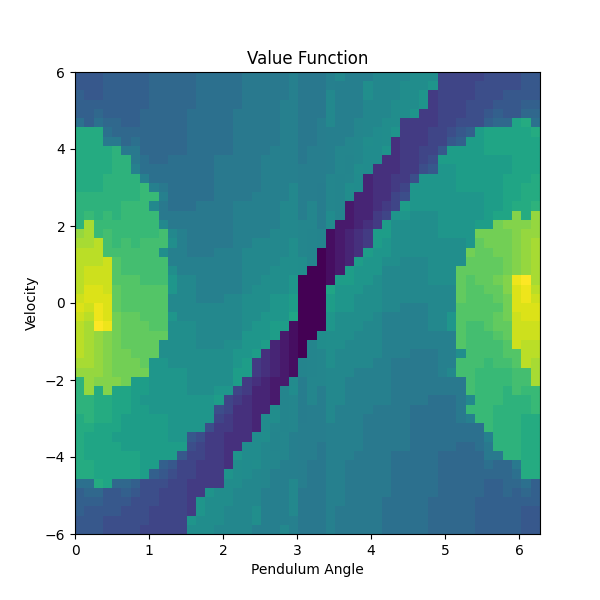

In [36]:
value_function=value_iteration.value_function

x0 = np.array([0.,0.])

x, u = robot.simulate(x0, policy, 20)
plot_value_function(value_function,nq,nv,v_max)

## 1.5 advantages and disadvantages

### advantages
Complexity of each iteration is only {\displaystyle O(S^{2}A)}
Will converge towards optimal values
Value iteration is good for a small set of states because we will avoid computing very deep expectimax trees which run in exponential time

### disvantages

Value iteration has to touch every state in every iteration and so if we have a large number of total states, value iteration suffers
It is slow because we have to consider all actions at every node, and often, there are many actions
The "max" at a state rarely changes. This means that the relative size of the Q values converge well before the values converge

## Part 2 - Tabular Q-learning
Now we want to implement the Q-learning algorithm (with a table and discretized states / actions). The difference with value iteration is that we will not assume that we can access the next state given any (x,u). We will need to run a realistic episode where we always start the pendulum at the position $[0,0]$.
1. Write a function ```q_learning(robot)``` that implements the tabular Q-learning algorithm (use episodes of 100 timesteps and an epsilon greedy policy with $\epsilon=0.1$). The function should return the Q-table as a 50x50x3 numpy array (assume that only three controls are possible as in Part 1).

2. How can you compute the optimal policy from the Q function? And the optimal value function? Write a function that does this using as an input the Q-table computed by ```q_learning(robot)```.

3. How many epsilodes (approximately) does it take for Q-learning to learn how to invert the pendulum when $u \in \{-5,0,5\}$? (use a learning rate of 0.1)

4. How does the estimates of the value function and policy compare to the ones computed with the Value Iteration algorithm? (plot these functions) Do you see any qualitative differences in terms of the computed policy compared to the optimal solution computed with value iteration? (e.g. do they achieve the same cost? did Q-learning find the optimal value function?  why?)

5. How is learning affected when changing $\epsilon$ and the learning rate?

6. Can you learn how to invert the pendulum with the sparse cost function define in Part 1.4? Is it easier or harder? Why?

##  implements tabular Q-learning

In [37]:
import random

In [38]:
class QLearningTable:
    """
    Skeleton class to help implement Q learning with a table
    """
    def __init__(self, model, cost,num_states,nu, discount_factor=0.99, learning_rate=0.1, epsilon_greedy=0.1):
        # we create tables to store value and policy functions
        self.value_function = np.zeros([num_states])
        self.policy = np.zeros([num_states])
        
        # we create the Q table
        self.q_function = np.zeros([num_states, nu])
        
        self.model = model
        self.cost = cost
        
        # other parameters
        self.epsilon = epsilon_greedy
        self.gamma = discount_factor
        self.alpha = learning_rate
        
        self.num_states=num_states
        self.nu=nu
            
    def iterate(self, u_table,num_iter=1):
        q_Last=np.zeros([num_states, nu])
        for i in range(num_iter):# 
            print('iteration {}'.format(i))
            # choose initial state x0
            x_0 = np.array([0,0])
            x_index = get_index(x_0)#random.randint(0, self.model.num_states-1)
            for j in range(2000):
                # choose an action using E-greedy policy
                if random.uniform(0, 1)>self.epsilon :
                    u_index = np.argmin(self.q_function[x_index,:])
                else:
                    u_index = random.randint(0,self.nu-1)
                # observe x_t+1
                next_index = next_state_index[x_index,u_index]
                # compute g(x_t,u(x_t))
                x=get_states(x_index)
                u=u_table[u_index]
                # compute TDerror
                TDerror=self.cost(x, u)+self.gamma*min(self.q_function[next_index,:])-self.q_function[x_index, u_index]
                self.q_function[x_index, u_index]=self.q_function[x_index, u_index]+self.alpha*TDerror
                x_index=next_index
                
            # we update the current Q function if there is any change otherwise we are done
            if ((q_Last-self.q_function)**2 < 10e-2).all() :
                break
            else:
                q_Last = self.q_function.copy()
        for k in range(self.num_states):
            self.policy[k]=u_table[np.argmin(self.q_function[k,:])]
            self.value_function[k]=min(self.q_function[k, :])

In [39]:
nq=50
nv=50
nu = 3
v_max = 6
u_max=5
# create lookup tables for discretized states
u_table = np.linspace(-u_max, u_max, nu)
q_table = np.linspace(0., 2*np.pi, nq, endpoint=False)
v_table = np.linspace(-v_max, v_max, nv)

num_states = nq * nv

In [40]:
# we instanciate a Q learning object for a pendulum model and a cost function
Q_Learning = QLearningTable(robot,cost,num_states,nu)

In [41]:
# we run the iterations (with maximum number 2000).

Q_Learning.iterate(u_table,2000)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

iteration 596
iteration 597
iteration 598
iteration 599
iteration 600
iteration 601
iteration 602
iteration 603
iteration 604
iteration 605
iteration 606
iteration 607
iteration 608
iteration 609
iteration 610
iteration 611
iteration 612
iteration 613
iteration 614
iteration 615
iteration 616
iteration 617
iteration 618
iteration 619
iteration 620
iteration 621
iteration 622
iteration 623
iteration 624
iteration 625
iteration 626
iteration 627
iteration 628
iteration 629
iteration 630
iteration 631
iteration 632
iteration 633
iteration 634
iteration 635
iteration 636
iteration 637
iteration 638
iteration 639
iteration 640
iteration 641
iteration 642
iteration 643
iteration 644
iteration 645
iteration 646
iteration 647
iteration 648
iteration 649
iteration 650
iteration 651
iteration 652
iteration 653
iteration 654
iteration 655
iteration 656
iteration 657
iteration 658
iteration 659
iteration 660
iteration 661
iteration 662
iteration 663
iteration 664
iteration 665
iteration 666
iterat

iteration 1171
iteration 1172
iteration 1173
iteration 1174
iteration 1175
iteration 1176
iteration 1177
iteration 1178
iteration 1179
iteration 1180
iteration 1181
iteration 1182
iteration 1183
iteration 1184
iteration 1185
iteration 1186
iteration 1187
iteration 1188
iteration 1189
iteration 1190
iteration 1191
iteration 1192
iteration 1193
iteration 1194
iteration 1195
iteration 1196
iteration 1197
iteration 1198
iteration 1199
iteration 1200
iteration 1201
iteration 1202
iteration 1203
iteration 1204
iteration 1205
iteration 1206
iteration 1207
iteration 1208
iteration 1209
iteration 1210
iteration 1211
iteration 1212
iteration 1213
iteration 1214
iteration 1215
iteration 1216
iteration 1217
iteration 1218
iteration 1219
iteration 1220
iteration 1221
iteration 1222
iteration 1223
iteration 1224
iteration 1225
iteration 1226
iteration 1227
iteration 1228
iteration 1229
iteration 1230
iteration 1231
iteration 1232
iteration 1233
iteration 1234
iteration 1235
iteration 1236
iteration 

iteration 1721
iteration 1722
iteration 1723
iteration 1724
iteration 1725
iteration 1726
iteration 1727
iteration 1728
iteration 1729
iteration 1730
iteration 1731
iteration 1732
iteration 1733
iteration 1734
iteration 1735
iteration 1736
iteration 1737
iteration 1738
iteration 1739
iteration 1740
iteration 1741
iteration 1742
iteration 1743
iteration 1744
iteration 1745
iteration 1746
iteration 1747
iteration 1748
iteration 1749
iteration 1750
iteration 1751
iteration 1752
iteration 1753
iteration 1754
iteration 1755
iteration 1756
iteration 1757
iteration 1758
iteration 1759
iteration 1760
iteration 1761
iteration 1762
iteration 1763
iteration 1764
iteration 1765
iteration 1766
iteration 1767
iteration 1768
iteration 1769
iteration 1770
iteration 1771
iteration 1772
iteration 1773
iteration 1774
iteration 1775
iteration 1776
iteration 1777
iteration 1778
iteration 1779
iteration 1780
iteration 1781
iteration 1782
iteration 1783
iteration 1784
iteration 1785
iteration 1786
iteration 

In [42]:
my_policy=Q_Learning.policy

def policy(x):
#     print(x)
    index=get_index(x)
    return my_policy[index]

<IPython.core.display.Javascript object>


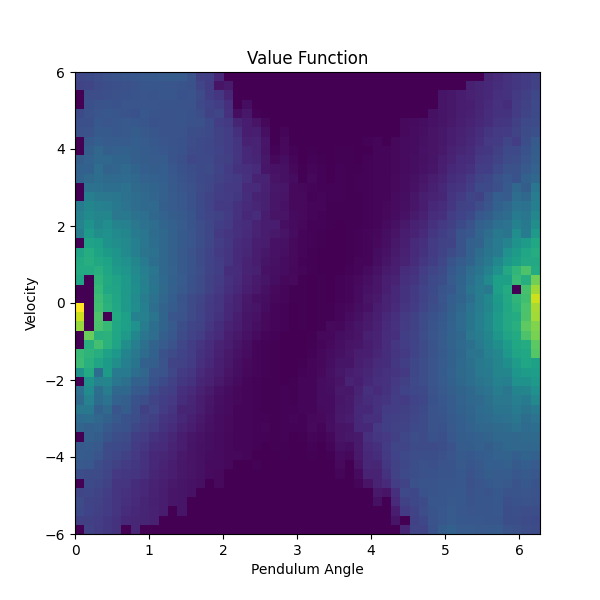

In [43]:
value_function=Q_Learning.value_function

x0 = np.array([0.,0.])

x, u = robot.simulate(x0, policy, 20)
plot_value_function(value_function,nq,nv,v_max)

<IPython.core.display.Javascript object>


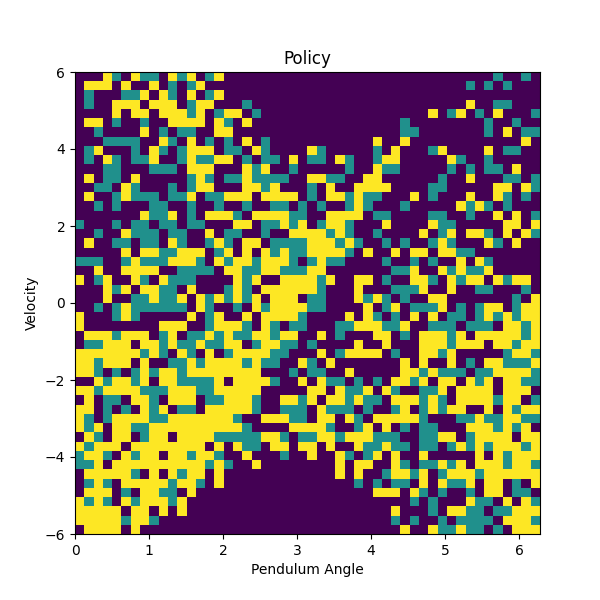

In [44]:
plot_policy(nq,nv,v_max,my_policy)

In [45]:
plot_results(robot, Q_Learning.value_function, policy,my_policy, animate=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQABIw1tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzA0OCBiODZhZTNjIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DQxliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsAD
pCLH/2+kONwAT9lg/NYjL/FoB9aiK4jE+YrYPvM3VJY4vjNnyLGP2YlbJp/NpA8k+C6YwpDlXn2f
y1TN9QNLS2doYg16nA3KBIICjrY2PQjGG/lJWgkVRima9js6Vx5WimbQrt72ItjNL7sLxElEA17m
hCeWbA7zyXROB8c1qwBwG6mF4Z9p4RctmYdY75fZ9PIcL6+1DtNo159DsIedHWW5BeeoUeMIr15+
LI/6q7q3wu/lDZN9tIlTOzRJ5hxurCa6TP3YdJ0Pua9/TkOnB1BZtIQdZE2NNeG6ZBWKX2qe8rir
o4hVHk6AK1m3pSBFYkubBzjVbb5azjAs67d441UqfxQIdZAC3wXGhd0Df4sjAsAiUQ3i9flvYL7N
AfNDl++9aqNS+m/EntCRwqCe8BI4h+X6tXM0ZlI2ui7fnCbPrzprCur/Qlv/AcWwh2PCPV27J9Hh
B4sbRpm2Il9JEsGqAKrFjtq/wKfkNJeUUJRqCO8O4BNTkM1gkUt/4YYDveK6vKxrr1xGInxBFkRx
Ra/U1q66FY5rPKRGvy/lhCV0gLPWM/Uwd4ACy0QsnRfL+3ezliZm8228ZiCQM/Bb7Hih+NU4fPzV
mXyFXbybWT3q7qlyOdubg07ODGm3wBRMgDYiJoXlKs5BQi05q90Qvp54LHZvlABc7azzgAAAlhgo
5U0yuXoovZ93mj5c0A4kViTmwfNlFN422rrmkY0+TJXjy2QETgxH+VjLUGW4nahqUgWQqDMfnRA9
lcxOpvul0EAwcmU/0ADaLvjFil9t7FUYKNxT6HPKJl9bOWLYqE+Cy39/mB8mN+2C9yTgeLkAYVNj
W62F82r/AqVC2BbuZp4VB+J9deuuOciIUAihH1mqc5GMh8KZmyduCGi7jBcE8GKK7Ktho1WaT7h0
oHuZDvhA+oN7r4xx/LU72e6n74sxOP/4YHwYrCx4uunVofIvqDyI8tU9VfBCymj6+aeibavntZjy
E6vpfbntb9PpYz8yDN5s//onJnSdeCwDlC2zfnnDF5/i64VFsUozdyzoOAFZ/mOly8BMmunCX7cf
EaLO2X2H1ysDqshseaIoXwWygaLYmg0cfvXwuNuwrlB3Aqslq3dmqH+bkl/IMTPLLYWS1C9hkmvX
rclkTwbXG5Uevo8/Y8+nCiH3D/Zq7F2gKNLavE+2AP95Hd2EkPlDbBe79z2sK2GzWNHkXpKoTBXE
7sZs3X4Gd10Rr1O9mWFyyCi5ByvTKE4cqyaIaGodepyLG5tdMu7I9bA1fuTbLaaRKYYnFukjysCp
Zscunqr9C/G6k2loU5XObNAXW1z6j6aCsOaps3mK/5EgXoG2DYw3kkwXGgOe0nyXws6Nmj1XO+Gc
C5K9qNuk0hCBDx22hJ1RwDhP7GBxi6kmbMAT9Iqc8Hrc7+c0jQOvp/3cXpWzFvWJYj6JoUMQGmrL
azCcsRoGIFgMV1YdzUufUQ4V4JN4jeBXuKBMpkk9IGolgAf6M3raUI4Bon85RDbtjjCNU7qk5DnA
gbvbThjevFs+lo7BZYCdl0hoy9fNDvKeCsdWloREGKKt5W4NJmNvkotQYqWWFBP9vV55qCo1/kN/
taXEB9B3l47hbrrIMoamGwyV5iZgAwzBg89EZ8AfrvJ76QYDm8als1XOEM52FLHkG4XCPUHDcv0w
BUS1yP3IHB2tKCU8ydjrKdcUC0QWGmDbSm+Qu4wDUigvVwFL9vLFArXPbOnttRCGO1F817aT3U65
FnA4HzL9pr+XEol/N1eX83BoiYmgGhwxIZj5w4Y3xvRo6LvGOWblt17GElzsF34+ffC1z4B8BZie
RoztbWJjU0u5fquzVFG/MQXGxRxqkoCVwO3KeQx9hW5R/FGtvYrfSsb98Akjnyejc94f/xvFcU4q
PSD0sw2ykpgtBu/KqO1K+6lJqGvYnF5lSCYu9Ui7KtkgzniXUQQ6IzwxFOlubxiY/X06kiOePtcC
fzSfKWr4K2uf69YAgBzTB2dkgfgTYFqUe5LSBPyYrsjPZdq6IzYurhHlL7P4n04gma2+PVsDb0UC
OjsY9nhuM9R/2Vrc/JQCKiZXUmG02Yej98b9/X0Sc6tCsjSxgFqm71h3aG0yuz3rFHX7/yc4Fs3u
JYt/5siee5XyZlnrrkcysdam7RGe2kLlMXJm29kfH8q7ty6K1DIHsd9t8u4eaGOLKbaAAh+pBlFI
P1paX8UlNIkmoUXGKar8htispAAAsTBSTCSa9cIxDIUM48sCKOXrH87gWjTh3+RlL0LhOH1w5sn6
50UNZUeoa71elm2HyaKYV7dNgADElbpQ3wIJ9tTYova2teF9Fu3Zgr8AAUcB5fAAY5FC//BmaaLB
p/1xFOFRwCVPWwFLCVL6tVdmOD8bES1AbeIx/6STfk4oaHgbYOqgGLSBGrciQYTlhE6MBOFD7XPj
MTq7R2SQKcddYtYmY4zuKEz24+bN7D7QX7xI2SXof3Hb2PzLXxbDVyMqy9k2bW1LnUL5Hz/HVAH6
OoBDmHa0f+wqSWpdgOXeZgkBc0A4eWCWQlh76azhx0w5S/MBh/fuxlVGq2PlqSMIishTp5u0JUDn
doO3AXbOYLuCdK1GrushgmdrnFvm9nScWzeOYKgP5b1UvmqmLqMyCMYZBF1ED1RwhTETSN8JFhx3
uiaSbSOjhX/1TtdGXBY8OgqmS+nbHjcBP5+/8+LD5sZjPBWXGZAisgqQX41UFuEokvdIXm/q9whN
D3z/uawXGXrw1Jrv/up0mrGCQyuvgy7OLnHi8FhE3Ofd8fTIJRU55l34hTqU00aIsxrN6wo17dNX
nD4EbecV2J2jmqk0QQqRE

##  learning with the sparse cost function

In [46]:
u_table = np.linspace(-u_max, u_max, nu)
q_table = np.linspace(0., 2*np.pi, nq, endpoint=False)
v_table = np.linspace(-v_max, v_max, nv)

In [47]:
# we instanciate a Q learning object for a pendulum model and a cost function
Q_Learning = QLearningTable(robot,cost1,num_states,nu)
# we run the iterations (with maximum number 2000).
Q_Learning.iterate(u_table,2000)

my_policy=Q_Learning.policy

def policy(x):
#     print(x)
    index=get_index(x)
    return my_policy[index]

plot_results(robot, Q_Learning.value_function, policy,my_policy, animate=True)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

iteration 598
iteration 599
iteration 600
iteration 601
iteration 602
iteration 603
iteration 604
iteration 605
iteration 606
iteration 607
iteration 608
iteration 609
iteration 610
iteration 611
iteration 612
iteration 613
iteration 614
iteration 615
iteration 616
iteration 617
iteration 618
iteration 619
iteration 620
iteration 621
iteration 622
iteration 623
iteration 624
iteration 625
iteration 626
iteration 627
iteration 628
iteration 629
iteration 630
iteration 631
iteration 632
iteration 633
iteration 634
iteration 635
iteration 636
iteration 637
iteration 638
iteration 639
iteration 640
iteration 641
iteration 642
iteration 643
iteration 644
iteration 645
iteration 646
iteration 647
iteration 648
iteration 649
iteration 650
iteration 651
iteration 652
iteration 653
iteration 654
iteration 655
iteration 656
iteration 657
iteration 658
iteration 659
iteration 660
iteration 661
iteration 662
iteration 663
iteration 664
iteration 665
iteration 666
iteration 667
iteration 668
iterat

iteration 1173
iteration 1174
iteration 1175
iteration 1176
iteration 1177
iteration 1178
iteration 1179
iteration 1180
iteration 1181
iteration 1182
iteration 1183
iteration 1184
iteration 1185
iteration 1186
iteration 1187
iteration 1188
iteration 1189
iteration 1190
iteration 1191
iteration 1192
iteration 1193
iteration 1194
iteration 1195
iteration 1196
iteration 1197
iteration 1198
iteration 1199
iteration 1200
iteration 1201
iteration 1202
iteration 1203
iteration 1204
iteration 1205
iteration 1206
iteration 1207
iteration 1208
iteration 1209
iteration 1210
iteration 1211
iteration 1212
iteration 1213
iteration 1214
iteration 1215
iteration 1216
iteration 1217
iteration 1218
iteration 1219
iteration 1220
iteration 1221
iteration 1222
iteration 1223
iteration 1224
iteration 1225
iteration 1226
iteration 1227
iteration 1228
iteration 1229
iteration 1230
iteration 1231
iteration 1232
iteration 1233
iteration 1234
iteration 1235
iteration 1236
iteration 1237
iteration 1238
iteration 

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQABvb1tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzA0OCBiODZhZTNjIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DQ5liIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOOM8Ue0I9hJLKvPs/l
qmb6oagJo7SFBr1OBuUCQQFG2xsmgmMN/KGNBIqjFM17HZsrECpFM2gzb3sRbGaX3YXhKCoBr2Vv
Btnz7czyXRN90c1rKBwG6h7+y1G9RctmKdYkNfZ9PIcL6+yDtJIOH1UIAuj9/wue2ZtEw6TSqBcK
L8eOssBoMcX7PXzJUsrbPviIbDjdWE10mfuw6TofcTbVsC7GFr0ZwVPYH+AOycAUFjmAGJk95XFX
RxCqPJz61rNvSkCKxJc2DnDq23y1nGBZ0W7xxqpU/igREKd8+qFqImDJ6q/ECIqJRDeL1+W9gvs0
B80Nn771qo1L6r8JJWhIyfsnvASOIfl+rVzNt0o2qwOxtlViXrpFGFdX+hJ/+A42nrNzSIvQobCb
1WYV+0aZtiJfPn6w1PvG4sdtX+BT8hpKEx+lGo4fw7gE1OQzWCRSf/UNjadsZRLvGuvYUKCdwTEk
WfopPqa1ddCsc1nlIPX5fys0H90Iqbz/qYO8ABZaIWjQvl/bvZyxMzeSWpapBIGfgt9jxS/GqcPn
5qzL5Crt5M3tXI70PXm9Vla/HVaCxgPICI90bCsIyVc4u3PdLfonjvTAsNJVxmETQokGg2YmVSOf
r9cf7n4gzRN5w/yGp0C8urfaPNw7GLtuDKgU7CvsIolbNMN0bp4uNQArcYt3tWUUqb0q6OjBYObX
juYjxUGZABKLLHFN/6veiTXwCvzZQezV/g5HRLV1YnFqdeWGDbkCWfZmb1bEe4o0ZC8xjpEr120J
my/+CpVN/LCBb43mUw7YT7/K5nbUFjE2fWbHzRkNPuFoiIUAihHtmqc5GMh8KZmydt11qyMhkGLn
FFXrtho2ClWJWeetPg1hhapwI4HkY4/lqd7PdT98WYnH/7fy4MVhY8XXUGTwUhNXsk8tjiPqeltX
ADyJRFFavntZkvu+zaX28uMbT6WM/MgzebP/5IgawXlFJWPgLbOX+bgXnmLrhUWxSjN3LOg4AVp4
GpLl2iUNdOEv24+I0WdswW69aIpab8sMQYo9BbKBotiaDRx+0fC427CuVpPCqyTnUBKn+gAX/8xj
yDIXb44+UHklBUWL3yDAQcoTDpE3sefTRQ4U9sUJGj2kFGltXifbADJsIu7CSHyhtgvd+57WFbDZ
rGkINclUJgrid2M2br78Wa6I16nezLC5Y4+Mg5XplCcOVZNENDUSvU5Fjc2umXdketI4v3JtltNI
lMLf8ZvD2Ct4L4VkDbV8ldY3b2loU5XObNAR21z6j6aCsOaps3mK/4YgXoG2DMw3uyw6wIwVtQDf
PAXiB6FL7fEAd7ZLSNNkgq5Y6qxbhTv4GypCJ/YwOR+tibzb7gsVb0ZCACQqRoeO0meB1bc4RCGP
3EvxnjjFfVXtPXK+PAtHDMhUtJ1q06vimCZzAzLnkf/PpDSnSRTRpKNk7s2HQCCHA6R/7qAxVQJM
KZQRz3gPQ/1CBGmSGgNjWvwUtGismjs+YIPz5wCFPcLWBPMf/rM9VUtCawds+MOb0nDAZTiqdu9x
n+2Wfc89ycU/Lt+dhvMn65Oyklc99L4vbTP1YaU1eg/y8MJrP7Y1ATy2rG0RANC4CL2QCgHCzO1K
THSFM6ny6/B9Uqi7aD/y61YkX6Q83rRuARseAP4Lt5TFDupog/wMXwRSO3oxM1tjhq3oarxRkFd5
O6TdIr7lmvpjlm6W2LJech160/hZdoZkWPXKT/8+W5fzcWmUTDXt0k0iQNbBoQ7DOWp6T3jHLN1V
Ioe51WdHNaLaYi8Aq+KCBHHI0Z2trEx3byBPWzHNFG/MQXGxRxnfFT0QduU8hj7C//l6stbexW+l
Y374BJHPk9G58N//yHvW6cVKTC+WYbZSUwVv6KflHalfdSk1DXtJbU2OHMXeqRdlWyYcf1mbyNJl
BoFHCepy8YmP19OpIjnj7UJQrf3ylq+CtsxOz5IaANre0OZ4n3QrSQ7/k4kQGo0yRkFgNG/nOgb2
hcGa28LjDuFGx0VzDF9+NCqylZiL1tOKHyT7j13Bo4nAmXX0OmecTsofb+74eb6frRalWZaBVne3
qNnmMEhK0Ie8a//ys2ik310rUehn0ETmZ7lfAXdpHsuEweAa3eQfStHd/ahkzY6kHoHYfWa7Ua8z
E7OQ7st6JxTaYmn0HJOnnYFCjX5GZmmpIuYKH2XMLlZLRD5EzqQLENABaflC7YWViiW1qvHs5JG1
Do5R3O1jhHHWPLyl0pQ7tiINSbeX8Zw9l7mMACcdAXsqYinBR//2lNrgAH7vjMQklfrQ75Mg+q11
n6hP9/EP+zVAPJ5OJYnfO9RCjSxJsrsesIBHoo53diVskH6Nvq5dUNS4xyuFrKnEk/UhNtNPUDJq
8wr4lPW5yIlyWGrISZEpvCQ/7wnYmw/3dFp60hHnHFsfdOsdPj+NBgKzafWdJhDJtGZW70Vz5RER
/50EKi4Qe+3W+JTQSmiYD7gF++Z8hIiO0gNGwqkXOYUGCdtMyf/rznDVaD955z83N4oNeFPn1/lh
zFHVvZz1ldG93qO3AkVs/gDBWxR8uG/6VgABbIAjgd2YrppMvMVWuPzsfkCvAzmnczaqJN4AbnTi
Vf9JKHkVz3fnvdQCA7s7al1YSKmTB8miHDmP/eyBFzfI+7L25g2sq0/FEsxgF91StMRfGoEmRXhz
f3jBAgzyZ5J6nIZjWcqd/7dW5w1iFKn4o+Jj3mp1CD7GSbXdvIbx2Z14FtbTYSvJ6H2bxbzGs1mq
l+4Gb9BiLOfMYOY8Wy+sD

<IPython.core.display.Javascript object>


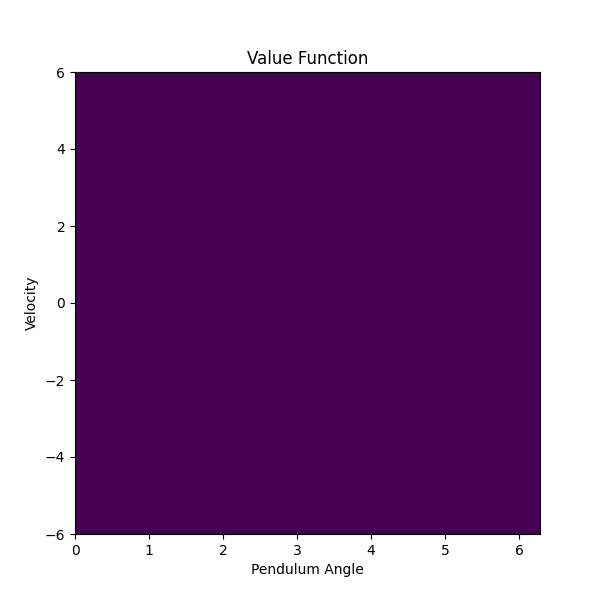

<IPython.core.display.Javascript object>


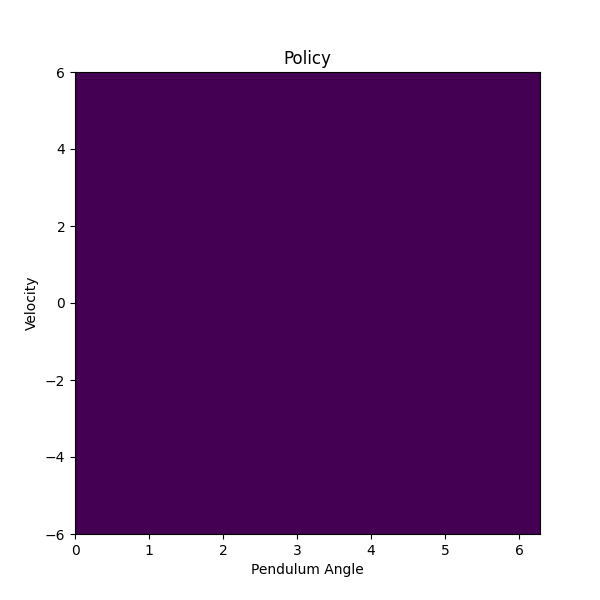

<IPython.core.display.Javascript object>


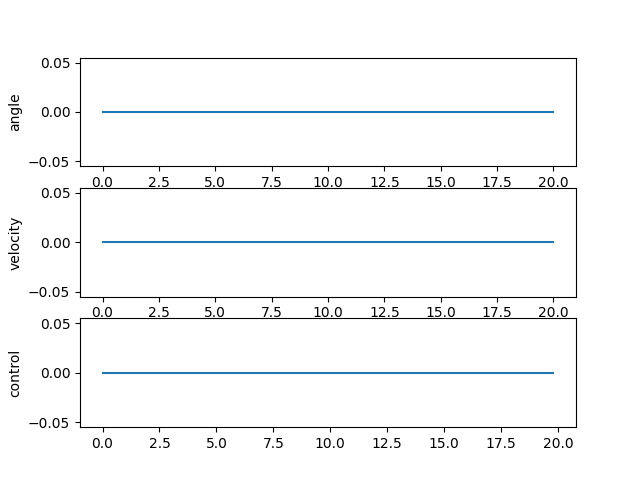

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAGyJtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSByMzA0OCBiODZhZTNjIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DR1liIQAEf/+94gfMstp+TrXchHnrS6tH1DuRnFepL3+IAAAAwAAAwACHHgr8h1jA36boAAANaAG
nDnk/0uKTTxANBMklOx5AfoyzTNjGZoxSMjI2XqpG5muyFpkpA6oCAPVnxylzDLYhuV6SiLysV19
ZrkfNVeuuW3Q9PnAIUDhMZl7zUCMeOI9XyhO34h2N6JqaLaBMEJBECZ+5uHUUpUwEyHMK0SddgK8
GQ+8N9YKy9+mi5xcrkYkRWJQER7+UzLKhVSfJl1dCKS9cKV2QpOCIcN2cB6dc7SsaFnK+lNL704K
VLG608M5FPwh6EL0EBwAfACHU1dX1oJZzgeYkF9jIDc1B3hLlj82wiQfYvK10RzuN9Q1U62r1Osc
ElerAZPXIcx/zTPnGxXw5umCITKeSjxzd7a4br1XC57E49S2VekK2ZcoSsDlXM3IXwr8wKVNTmii
S4/b2C6vQHzLa8snanJg+/rHy8lm80ZnrrjDHhzJMv9fPnzZXf6By7qlajFITt+t8f783P8Mz+Tg
usP5W1SLsMI3NM2xEvgKqVlwK5xY60lN12x7Sxb1UVNJQyHZWr/RBporGZP8yOHAwfJClNMX63fD
m8c59mi2E3q6GhztvWsCyOWh5judEAR3Mtt2SCs6HGEaSgYlXuEYHT/GFbYFW7BXW0mAvXEkEOo0
UO9lDqteHlDvCaab1EPQmssAofZbyBtCTx3gEoMqaxYBPT+PMNxp5Id+nGQWNyIRQ5iQsavyx2XM
b2W+ctDOiAAAAwAAAwAAAwDi8TUQsOltUp9/zuyGXwr0yoBpPkI8Le10cSCSaiKEjR9DlGkxWnnt
zlAQc7spaDgRFnsCpcyIFIxWtTXY7YGA8qUN/W4+qlML9qxyaJB+go3FPoc8omXrA5YtioT4LLf3
t5xpv8DlNSbtLxcGTG0163Wwvm1f4DggHQFu5mnhUH4ni06/M5yIhQCK4hGapzkYyHwpmbI08imp
thgTTwYorp02GCn3MRIzz1p8GsMLVOBAw8jHH8tTvZ7qfvizDqv/gxiS3CZEhjz4bo1ANtQRCYOH
9MhqpclX0vh4Ake58GmHwvpaW/j5W/T6WIZmxNCL5/4Q/zj7RiqEs8yMCmK2E3zzz0MtCD/qerWb
ZfMIDRGW+UyzVu07NHZ9jsGJpX9T28ny+ZYn0dRiOOHVIKIFeWU9gkKP6zVw95aBJJICQ6IN3zPJ
iVXBQAAAAwAAAwABdmLmf4DwmPkj9ThNpZM5EdrdhZaPBTLMtoYnshunUr3b/iEHRbD7+mdeCkBH
DSJkvKT3m+mOd9ep3sywhkUj9wOV6ZQnDlWTRDidJIjqn6dEZ6IQ4r5cfw9ybZbTSJS83st0keVg
VLNqIWhiZj+2P29paFOVzmzi01tc+o+mgrDmqbN7cp+jGY6AYzbhO/KzDlBhmxN8l8LOjZo9VzKg
sTcwBcUdJpCEOcB+a+OjmpwT+xeWzOkrjaIrSRlcn5REEoMZqHyUlx1OJmE/31vTunVFcVHyNule
Iugh2fggxq5mma+AF84wQRhTy1nhzsoJTX8XZGc0z5816aJ91V1O7tRupt5/4ETEe3lMWWkMPHdf
VKJmY1EZHh/y3LSzOPpLp4t/8EAcIpt88AuNFrpmdhf1+48MBlOKp277u+NIfROAMtU70vf40gJ9
ZQuQpkUgS44x/X0mQsw/biA0pXQrwU9eZNfVSTKiX/HQQJ0dGhdeLGlq1K03kqS8pe5dF2X/1N5v
xBI7jEEq863lCQ0ubGfGEf6Y14D2AjQ1wVgTSIBq3/046plAk/J0WOxYVMuPNlJrSuJKXk84hu5i
ZyN+t2HpxD/E2MzbBJdzDRRm7MYePkXjeP/i5nFPvl49Ch8gV9/iPhPA0QMM56NNfNwiNqv7kYyy
PEB/ZFo8DcWGPtLZ2ljWwnzH7HH1aqHvYuYThAVZXalgqUhwK+zrgduU8hj7EhoPYa1/z+W+lY37
lz2XTT0bnn6X+O4z+xZsl+P1VY85tKy7ww157rpIVDKTUNexOPrK/4xiXPUtBZwVsaJdv32G8Ama
H7MeVebfYMbM3Wb7rpF3AtM2yjpkeiLmiUKZJ3p62EP8+qUb705drdcuCa+5MirGTzNAJYurhHlL
7AUn04gma2+PVs9HwC/jnPOtHhuM9Sv2Qre7IQb2V1yIui2uFCm9XZ+v3s5Fj1aCLvWS6qVtjdxj
BIStCHvGGf+1wpVPR3sx16o9S+d/duSmMyILpNTHXVlo6TOvDRjDbigpIDtARuUAVmu1GvMxOzmc
VNSqrQ4CzKjq71nkC82IQhynmww5niN/ssPMhr6WKqVeCcdEG2Gd2L9Z7lOPUkdCgqkxF12axYNi
P71HhvfSKyRpKn0zRc0UKvJhPN9g2yyXAAADAPUAAAMABF5asfTGZ5SBX2cLRngvpUoeWFL22qwD
Tu5kRQDFpAjVuRIMJywnrlKfPR9rnxmJ1do7ILOd4q3VjusTB94unCv20cPKta+28Xr3N3O2W6pZ
TCBB8qbf+0NZQ81UuBz2ykEKrKgKCYOjbYJTVIAVTjoXxCUx+FLDhiJoum5/SdXSeVohiMVnOb9O
G58aruQUQr/rJidg9d1yCirihGKX6JoJ6yyjRdnJ4QHCfQvXKXk79KbUV0doxOxB+ndp5oNXdZDB
M1Z+KTp3K5BaNMeVCkj+W9YdX+ofxiN1qKM0OcbB6o4QpiJpG+eCzKXUE85hzxIhRpv1dMAULMeH
QVTJfTtjxuAn89P/bC/+cQm+b2/tBd9Y/I1MB6dwwlEl7tvkM/+KFcFUo+qTdht4E1OQzGs5br/6
LNLCyP7HZFZ9GJDkpa6zH3IIwmNo/LJaDEQoa7T4JjSJaylDT3dB/RxdTFUtQ/AxMlTNTt/sOnLl
7OQb/XdmZvlHPt0l/zoDj

In [48]:
# here is some code to plot results, assuming a policy and a value function are given
# this can be used to answer questions in both Part 1 and 2


# we make a robot
robot = pendulum.Pendulum()

value_function = np.zeros([50,50])
policy = np.zeros([50,50])

# we plot the value function
plt.figure(figsize=[6,6])
plt.imshow(value_function, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')

# we plot the policy
plt.figure(figsize=[6,6])
plt.imshow(policy, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')

# now we simulate the dynamics for 100 time steps
x0 = np.array([0.,0.])

def controller(x):
    theta = np.linspace(0, 2*np.pi, 50, endpoint=False)
    dtheta = np.linspace(-6, 6, 50)
    
    th_index = np.argmin(np.abs(theta - x[0]))
    dth_index = np.argmin(np.abs(dtheta - x[1]))
    return policy[th_index, dth_index]

x, u = robot.simulate(x0, controller, 10)

# and plot the results
time = np.linspace(0.,20., len(x[0,:]))
plt.figure()
plt.subplot(3,1,1)
plt.plot(time,x[0,:])
plt.ylabel('angle')
plt.subplot(3,1,2)
plt.plot(time,x[1,:])
plt.ylabel('velocity')
plt.subplot(3,1,3)
plt.plot(time[:-1],u)
plt.ylabel('control')

# and show an animation
robot.animate_robot(x, robot.delta_t)